importing all the required modules

In [1]:
import torch
import os
import librosa
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import scipy
from glob import glob
import matplotlib.pyplot as plt
import custom_transforms as CT
import torchvision.transforms as T
from generative.networks.nets import VQVAE as VQVAE_MONAI
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt

2025-02-03 11:49:58.357825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738601398.368550 3906474 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738601398.371836 3906474 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 11:49:58.383845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/yagna/yagnaPythonEnv/lib/python3.12/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `to

Defining the Dataset

In [2]:
import torch
from torch.utils.data import Dataset
import librosa
import numpy as np
import scipy
import os
from glob import glob

class AudioMNIST(Dataset):
    def __init__(self, root, target_sample_rate=12000, duration=None, transform=None):
        super(AudioMNIST, self).__init__()
        self.root = root
        self.target_sample_rate = target_sample_rate
        self.duration = duration
        self.transform = transform
        self.wav_files = glob('*/*.wav', root_dir=root, recursive=True)
        self.n_fft = 512

    def get_spectrogram(self, waveform):
        f, t, Zxx = scipy.signal.stft(
            waveform, 
            self.target_sample_rate,
            nperseg=self.n_fft//2,
            noverlap=self.n_fft//4,
            window='hann'
        )
        Zxx = Zxx[0:128, :-1]
        
        # Normalize amplitudes
        amplitudes = np.abs(Zxx)
        phases = np.angle(Zxx)
        
        self.amp_min = np.min(amplitudes)
        self.amp_max = np.max(amplitudes)
        
        eps = 1e-10
        normalized_amplitudes = (amplitudes - self.amp_min) / (self.amp_max - self.amp_min + eps)
        Zxx_normalized = normalized_amplitudes * np.exp(1j * phases)
        
        return Zxx_normalized

    def twod_to_complex(self, tensor):
        tmp_tensor = tensor.reshape(2, tensor.shape[1]*tensor.shape[2])
        complex_data = tmp_tensor[0,:] + 1j * tmp_tensor[1,:]
        
        # Denormalize amplitudes
        amplitudes = np.abs(complex_data)
        phases = np.angle(complex_data)
        
        denorm_amplitudes = amplitudes * (self.amp_max - self.amp_min) + self.amp_min
        new_tensor = denorm_amplitudes * np.exp(1j * phases)
        
        return new_tensor.reshape(1, tensor.shape[1], tensor.shape[2])

    def complex_to_2d(self, tensor):
        new_tensor = np.zeros((2, tensor.shape[0]), dtype=np.float64)
        new_tensor[0] = np.real(tensor).astype(np.float64)
        new_tensor[1] = np.imag(tensor).astype(np.float64)
        return new_tensor


    def __getitem__(self, index):
        file_name = os.path.join(self.root, self.wav_files[index])
        label = int(os.path.basename(file_name)[0])
        waveform, _ = librosa.load(file_name, sr=self.target_sample_rate, duration=self.duration)
        
        if self.transform is not None:
            waveform = self.transform(waveform)
            
        Zxx = self.get_spectrogram(waveform)
        datapoint = self.complex_to_2d(Zxx.flatten())
        datapoint = datapoint.reshape(2, 128, 125)
        datapoint = datapoint[:,:,:44]
        return torch.tensor(datapoint, dtype=torch.float32), label
    
    def __len__(self):
        return len(self.wav_files)

In [3]:
transforms = [CT.TrimSilence(5), CT.FixLength(16000)]
dataset = AudioMNIST('../Data', transform=T.Compose(transforms))

In [4]:
model = VQVAE_MONAI(
            spatial_dims=2,
            in_channels=2,
            out_channels=2,
            num_res_layers=2,
            downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
            upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
            num_channels=(256, 256),
            num_res_channels=(256, 256),
            num_embeddings=256,
            embedding_dim=32
        ).to(device='cuda:0')

In [5]:

train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    persistent_workers=True
)

In [6]:
# epochs = 20
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# for epoch in range(epochs):
#     model.train()
#     train_losses = []
#     for data, label in tqdm(train_loader):
#         images = data.to(device='cuda:0')
#         reconstruction, quantization_loss = model(images)
#         recons_loss = F.l1_loss(reconstruction, images)
#         loss = recons_loss + quantization_loss
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         train_losses.append(loss.item())
    
#     avg_train_loss = sum(train_losses) / len(train_losses)
#     print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}")
    
#     model.eval()
#     val_losses = []
    
#     with torch.no_grad(): 
#         for data, label in tqdm(val_loader):
#             images = data.to(device='cuda:0')
#             reconstruction, quantization_loss = model(images)
#             recons_loss = F.l1_loss(reconstruction, images)
#             loss = recons_loss + quantization_loss
            
#             val_losses.append(loss.item())
    
#     avg_val_loss = sum(val_losses) / len(val_losses)
#     print(f"Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}")

In [7]:
torch.save(model,"final_model.pt")

/tmp/ipykernel_3906474/884366239.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/vqvae_monai.pth").to(device='cuda:0')


(1, 128, 44)


/tmp/ipykernel_3906474/884366239.py:7: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  Img = librosa.amplitude_to_db(Complex, ref = np.max)


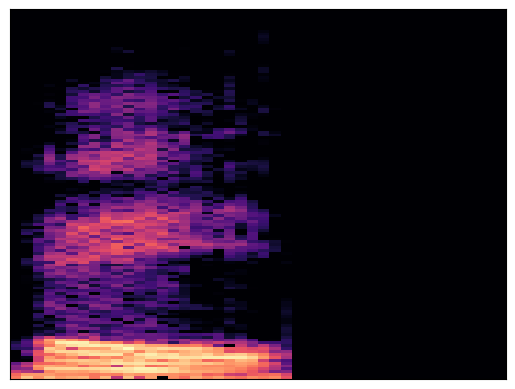

In [7]:
model = torch.load("saved_models/vqvae_monai.pth").to(device='cuda:0')
model.eval()

sample1 = dataset[66][0]

Complex= dataset.twod_to_complex(sample1)
Img = librosa.amplitude_to_db(Complex, ref = np.max)
print(Img.shape)
librosa.display.specshow(Img[0])

In [9]:
_,x = scipy.signal.istft(Complex, 12000)
        # get amplitude
print(x.shape)

from IPython.display import Audio
Audio(data=x, rate=12000)

(1, 5461)


torch.Size([1, 2, 128, 44])
(1, 128, 44)


/tmp/ipykernel_3293576/319081470.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  Img = librosa.amplitude_to_db(reconComplex, ref = np.max)


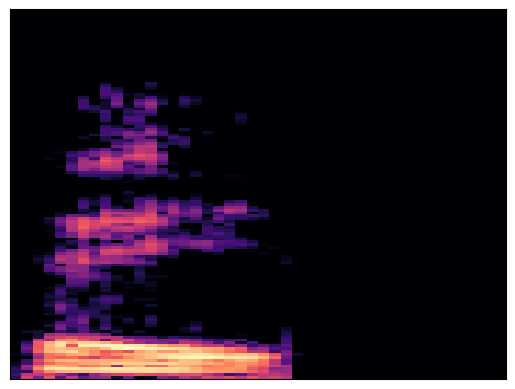

In [10]:
sample1Batch = sample1.unsqueeze(0).to("cuda:0")
print(sample1Batch.shape)
sample1_reocn = model(sample1Batch)[0].cpu().detach().numpy()

reconComplex= dataset.twod_to_complex(sample1_reocn[0])
Img = librosa.amplitude_to_db(reconComplex, ref = np.max)
print(Img.shape)
librosa.display.specshow(Img[0])



In [11]:
_,x = scipy.signal.istft(reconComplex, 12000)
        # get amplitude
print(x.shape)

from IPython.display import Audio
Audio(data=x, rate=12000)

(1, 5461)


In [12]:
real_indices = model.model.index_quantize(model(sample1Batch)[0].to(device='cuda:0'))

In [13]:
real_indices = real_indices.flatten()

In [ ]:
real_recon = model.model.decode_samples(real_indices.reshape(1,32,11))
real_recon_complex = dataset.twod_to_complex(real_recon[0].cpu().detach().numpy())
Img_real_recon = librosa.amplitude_to_db(real_recon_complex, ref = np.max)
print(Img_real_recon.shape)
librosa.display.specshow(Img_real_recon[0])

_,x = scipy.signal.istft(real_recon_complex, 12000)
        # get amplitude
print(x.shape)

from IPython.display import Audio
Audio(data=x, rate=12000)

In [ ]:
context = torch.tensor([[2]]).to(device='cuda:0')
transformer = torch.load('saved_models/MONAI_Transformer_epochs_100.pt').to(device = 'cuda:0')

fake_indices = transformer.generate(context,max_new_tokens=352).flatten()[1:].reshape(1,32,11)

fake_recon = model.model.decode_samples(fake_indices)

fake_recon_complex = dataset.twod_to_complex(fake_recon[0].cpu().detach().numpy())
Img_fake = librosa.amplitude_to_db(fake_recon_complex, ref = np.max)
print(Img_fake.shape)
librosa.display.specshow(Img_fake[0])

_,x = scipy.signal.istft(fake_recon_complex, 12000)
        # get amplitude
print(x.shape)

from IPython.display import Audio
Audio(data=x, rate=12000)

In [ ]:
context = torch.tensor([[6]]).to(device='cuda:0')
transformer = torch.load('saved_models/Transformer_epochs_100.pt').to(device = 'cuda:0')
fake_indices = transformer.generate(context,max_new_tokens=352).flatten()[1:].reshape(1,32,11)

fake_recon = model.model.decode_samples(fake_indices)

fake_recon_complex = dataset.twod_to_complex(fake_recon[0].cpu().detach().numpy())
Img_fake = librosa.amplitude_to_db(fake_recon_complex, ref = np.max)
print(Img_fake.shape)
librosa.display.specshow(Img_fake[0])

_,x = scipy.signal.istft(fake_recon_complex, 12000)
        # get amplitude
print(x.shape)

from IPython.display import Audio
Audio(data=x, rate=12000)

In [14]:
def generate(model, idx, max_new_tokens):
    """
    Generate a sequence of tokens based on the initial context `idx`.

    Args:
        idx (torch.Tensor): Initial context of shape (B, T) with indices.
        max_new_tokens (int): Number of tokens to generate.

    Returns:
        torch.Tensor: Generated sequence of shape (B, T + max_new_tokens).
    """
    model.eval()  # Ensure the model is in evaluation mode

    with torch.no_grad():  # Disable gradient computation for inference
        for _ in range(max_new_tokens):
            # Crop `idx` to the last `block_size` tokens for efficient processing
            idx_cond = idx[:, -model.block_size:]

            # Forward pass to get logits
            logits = model(idx_cond)

            # Focus only on the last time step (prediction for the next token)
            logits = logits[:, -1, :]  # Shape: (B, vocab_size)

            # Remove probabilities for tokens with index >= 256
            logits[:, 256:] = 0

            # Convert logits to probabilities using softmax
            probs = F.softmax(logits, dim=-1)  # Shape: (B, vocab_size)

            # Sample the next token from the probability distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # Shape: (B, 1)

            # Append the sampled token to the sequence
            idx = torch.cat((idx, idx_next), dim=1)  # Shape: (B, T + 1)

    return idx

/tmp/ipykernel_3906474/1353698556.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load('saved_models/MONAI_Cond_Transformer_epochs_30.pt').to(device = 'cuda:0'

(1, 128, 44)
(1, 5461)


/tmp/ipykernel_3906474/1353698556.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  Img_fake = librosa.amplitude_to_db(fake_recon_complex, ref = np.max)


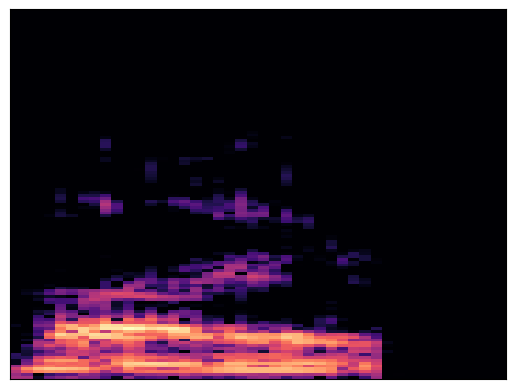

In [33]:
from src.TransformerMonai import MonaiDecoderOnlyModel
label = 5
BOS_TOKEN = 256
device = 'cuda:0'
context = torch.tensor([[BOS_TOKEN, 257 + label]], dtype=torch.long, device=device)
m = torch.load('saved_models/MONAI_Cond_Transformer_epochs_30.pt').to(device = 'cuda:0')
generated = m.generate(context, max_new_tokens=352)
indices = generated[0, 2:]
fake_indices = indices.view(1, 32, 11)

fake_recon = model.model.decode_samples(fake_indices)

fake_recon_complex = dataset.twod_to_complex(fake_recon[0].cpu().detach().numpy())
Img_fake = librosa.amplitude_to_db(fake_recon_complex, ref = np.max)
print(Img_fake.shape)
librosa.display.specshow(Img_fake[0])

_,x = scipy.signal.istft(fake_recon_complex, 12000)
        # get amplitude
print(x.shape)

from IPython.display import Audio
Audio(data=x, rate=12000)

/tmp/ipykernel_3906474/264855861.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load('saved_models/NanoGPT_Cond2_Transformer_epochs_30.pt').to(device = 'cuda:

torch.Size([1, 2, 128, 44])
tensor(-0.5471, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5300, device='cuda:0', grad_fn=<MaxBackward1>)
3.1564305e-08 0.0012720099
(1, 128, 44)
(1, 5461)


/tmp/ipykernel_3906474/264855861.py:18: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  Img_fake = librosa.amplitude_to_db(fake_recon_complex, ref = np.max)


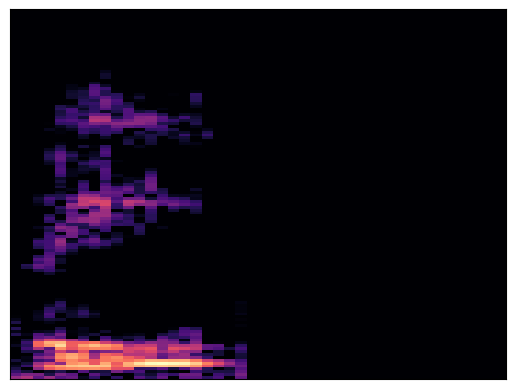

In [58]:
from trainTransformerNanoGPTCond import *
label = 8
BOS_TOKEN = 256
device = 'cuda:0'
context = torch.tensor([[BOS_TOKEN, 257 + label]], dtype=torch.long, device=device)
m = torch.load('saved_models/NanoGPT_Cond2_Transformer_epochs_30.pt').to(device = 'cuda:0')
generated = m.generate(context, max_new_tokens=352)
indices = generated[0, 2:]
fake_indices = indices.view(1, 32, 11)

fake_recon = model.model.decode_samples(fake_indices)
print(fake_recon.shape)
print(fake_recon.min(), fake_recon.max())

fake_recon_complex = dataset.twod_to_complex(fake_recon[0].cpu().detach().numpy())
print(np.abs(fake_recon_complex).min(), np.abs(fake_recon_complex).max())

Img_fake = librosa.amplitude_to_db(fake_recon_complex, ref = np.max)
print(Img_fake.shape)
librosa.display.specshow(Img_fake[0])

_,x = scipy.signal.istft(fake_recon_complex, 12000)
        # get amplitude
print(x.shape)

from IPython.display import Audio
Audio(data=x, rate=12000)

In [57]:
import numpy as np
from scipy.io.wavfile import write

# Your NumPy array
array = x  # Example array, replace with your actual data

# Normalize to the range of int16 (if necessary)
array = array / np.max(np.abs(array))  # Normalize between -1 and 1
array = (array * 32767).astype(np.int16)  # Convert to int16

# Save as WAV file
sample_rate = 12000  # Set an appropriate sample rate (adjust as needed)
write("output.wav", sample_rate, array.T)  # Transpose to match WAV format


In [53]:
x.shape

(1, 5461)

In [ ]:
import soundfile as sf 